# Heatmaps
This example demonstrates how to create **interactive heatmaps** with **earthkit-plots**.  
Heatmaps are useful for visualising spatial and temporal patterns, either as **categorical classes** (discrete bins) or **continuous gradients**.

# Example 1: Thunderstorm probability (mock data)
In this first example, we generate mock thunderstorm probabilities around Zurich Airport (Kloten).  
The values are smoothed and normalised to produce realistic-looking forecasts.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage import gaussian_filter

time_objects = pd.to_datetime(pd.date_range('2025-06-10T00:00:00', periods=36, freq='h'))
time_coords = time_objects.strftime('%Y-%m-%d %H:%M')

locations = ['KLO', 'W', 'S', 'E', 'Schluchsee']
dims = ('location', 'time')
shape = (len(locations), len(time_coords))

# Realistic distribution for thunder (points close to each other are similar)
random_probabilities = np.random.rand(*shape)
smooth_probabilities = gaussian_filter(random_probabilities, sigma=(1.0, 3.0))
normalized_probabilities = (smooth_probabilities - smooth_probabilities.min()) / (smooth_probabilities.max() - smooth_probabilities.min())
skewed_probabilities = normalized_probabilities ** 4

mock_data = xr.DataArray(
    data=skewed_probabilities * 100,
    coords={'location': locations, 'time': time_coords},
    dims=dims,
    name='thunderstorm_and_cb_probability_1h'
)

## Categorical heatmap
A **categorical heatmap** groups continuous data into discrete bins, each with a specific color. This is extremely useful for communicating levels of risk or predefined thresholds (e.g., "Low," "Medium," "High"). It simplifies the visualization, making it easy to interpret at a glance.

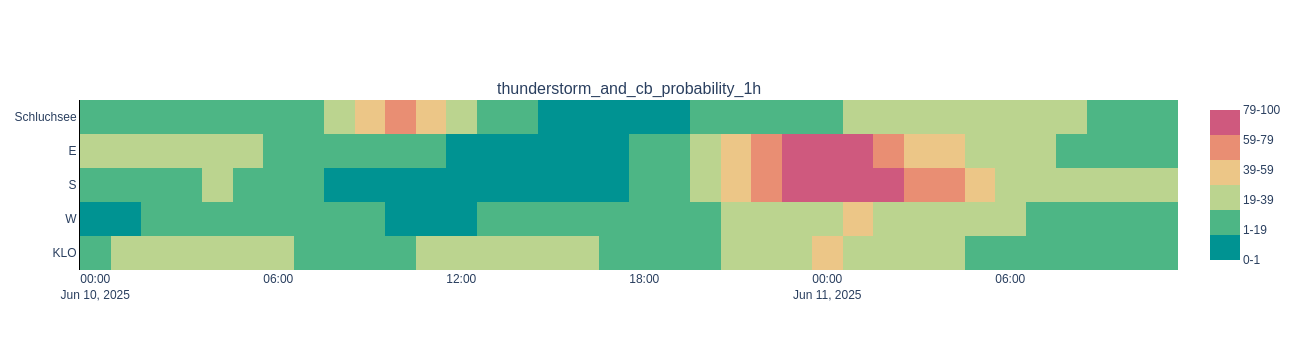

In [2]:
from earthkit.plots.interactive import Chart

chart = Chart()

chart.heatmap(
    mock_data,
    style="categorical",
    # bins=[0, 1, 20, 40, 60, 80, 100],
    # bin_labels=["<1%", "1-20%", "20-40%", "40-60%", "60-80%", "80%+"], # Optional: Custom labels for bins
    colorscale="temps"  # You can use any valid Plotly colorscale
)

chart.show(renderer="png", width=1300, height=350)

## Continuous heatmap
A **continuous heatmap**, on the other hand, maps each value to a color along a smooth gradient. This style is better for seeing subtle variations and the precise evolution of the data without the simplification of binning.

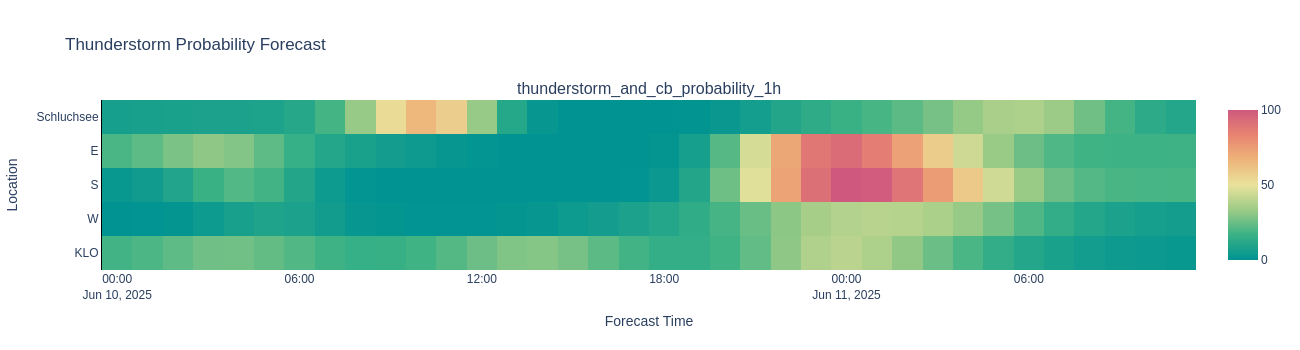

In [3]:
chart = Chart()

chart.heatmap(
    mock_data,
    style="continuous",
    colorscale="temps"
)

chart.title("Thunderstorm Probability Forecast")
chart.fig.update_layout(
    xaxis_title="Forecast Time",
    yaxis_title="Location",
)

chart.show(renderer="png", width=1300, height=350)

# Example 2: Daily maximum temperature calendar (Zürich, 2023)
Here we use the [Open-Meteo Climate API](https://open-meteo.com/) to fetch daily maximum temperature for Zürich in 2023. 

In [4]:
import requests

url = "https://climate-api.open-meteo.com/v1/climate"
params = {
    "latitude": 47.38,
    "longitude": 8.54,
    "start_date": "2023-01-01",
    "end_date": "2023-12-31",
    "models": ["EC_Earth3P_HR"],
    "daily": "temperature_2m_max",
}

response = requests.get(url, params=params, verify=False)
data = response.json()

daily_data = data['daily']
df = pd.DataFrame(data=daily_data)
df['time'] = pd.to_datetime(df['time'])
print("Data fetched successfully!")

Data fetched successfully!


/home/pls/earthkit-plots/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:2299: InsecureRequestWarning:

Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3future.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



The data is aggregated by **month and day** to form a "calendar-style" heatmap.  

In [5]:
# Aggregate by month and day
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

heatmap_df = df.pivot_table(
    index='month',
    columns='day',
    values='temperature_2m_max'
)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_df.index = [month_names[i-1] for i in heatmap_df.index]


calendar_temp_data = xr.DataArray(
    heatmap_df,
    dims=('month', 'day'),
    coords={'month': heatmap_df.index, 'day': heatmap_df.columns}
)

This view highlights seasonal cycles and unusual hot/cold days.

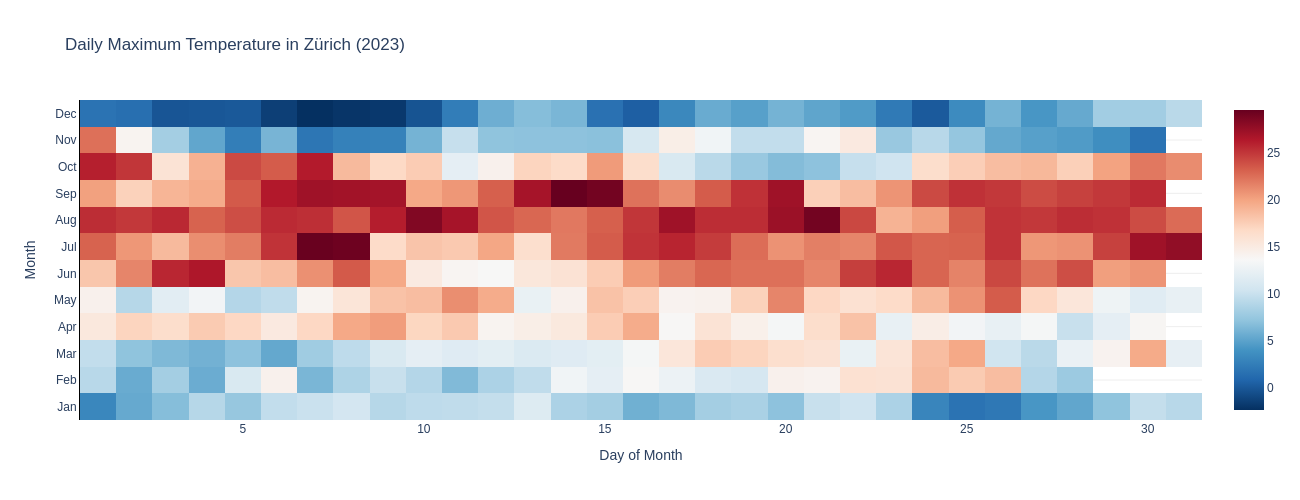

In [6]:
chart = Chart()

chart.heatmap(
    calendar_temp_data,
    style="continuous",
    colorscale="RdBu_r"
)

chart.title("Daily Maximum Temperature in Zürich (2023)")
chart.fig.update_layout(
    xaxis_title="Day of Month",
    yaxis_title="Month"
)

chart.show(renderer="png", width=1300, height=500)

# Example 3: Long-term temperature anomalies (Zürich, 1951–2050)
In the final example, we calculate temperature anomalies relative to a **1951–1980 climatological baseline**.  

In [7]:
import requests
import pandas as pd
import xarray as xr
from earthkit.plots.interactive import Chart

url = "https://climate-api.open-meteo.com/v1/climate"
params = {
    "latitude": 47.38,
    "longitude": 8.54,
    "start_date": "1951-01-01",
    "end_date": "2050-12-31",
    "models": ["EC_Earth3P_HR"],
    "daily": "temperature_2m_mean",
}

response = requests.get(url, params=params, verify=False)
data = response.json()

daily_data = data['daily']
df = pd.DataFrame(data=daily_data)
df['time'] = pd.to_datetime(df['time'])
print("Data fetched successfully!")


/home/pls/earthkit-plots/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:2299: InsecureRequestWarning:

Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3future.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Data fetched successfully!


For each month, we compute the long-term mean during the baseline, subtract it from the daily data, and average anomalies by month and year.  

In [8]:
# Aggreate by year and month
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# Baseline period for the long-term average
baseline_start_year = 1951
baseline_end_year = 1980

# Filter the DataFrame to the baseline period
baseline_df = df[
    (df['year'] >= baseline_start_year) & (df['year'] <= baseline_end_year)
]

# Calculate the mean temperature for each calendar month within the baseline period
monthly_baseline_temps = baseline_df.groupby('month')['temperature_2m_mean'].mean()

# Map the baseline temperatures to each row in the original DataFrame
# This gives each day the corresponding long-term average for its month
df['baseline_temp'] = df['month'].map(monthly_baseline_temps)

# Calculate the daily anomaly (difference from the monthly baseline)
df['anomaly'] = df['temperature_2m_mean'] - df['baseline_temp']

In [9]:
# Create a pivot table of the mean monthly anomaly
# This aggregates the daily anomalies into a single value for each month
anomaly_heatmap_df = df.pivot_table(
    index='year',
    columns='month',
    values='anomaly',
    aggfunc='mean'
)

# Convert the pandas DataFrame to an xarray.DataArray for plotting
anomaly_data_2d = xr.DataArray(
    anomaly_heatmap_df,
    dims=('year', 'month'),
    coords={'year': anomaly_heatmap_df.index, 'month': anomaly_heatmap_df.columns}
)

This produces a two-dimensional heatmap of anomalies:  
- the vertical axis shows years,  
- the horizontal axis shows months,  
- the color indicates the departure from the baseline temperature.  

This style of plot is used in climate science to visualise trends and variability over decades.

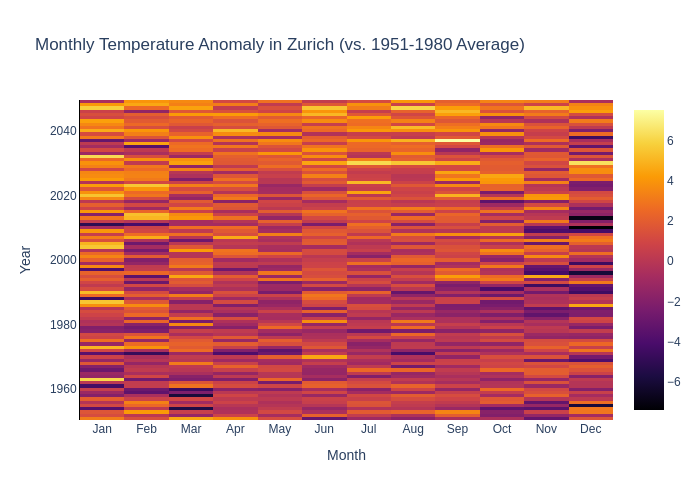

In [10]:
chart = Chart()

chart.heatmap(
    anomaly_data_2d,
    style="continuous",
    colorscale="inferno"
)

chart.title(f"Monthly Temperature Anomaly in Zurich (vs. {baseline_start_year}-{baseline_end_year} Average)")
chart.fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Year",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    coloraxis_colorbar=dict(
        title="Anomaly (°C)"
    )
)

chart.show(renderer="png")